In [43]:
%load_ext autoreload
from ddls.distributions.custom_skew_norm import CustomSkewNorm
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally

from ddls.plotting.plotting import PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import copy

from omegaconf import OmegaConf
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/scratch/zciccwf/py36/envs/ddls/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
%autoreload

# seed
import torch
import numpy as np
import random
seed_stochastic_modules_globally(np, random, torch, default_seed=0)

# generate dists
context_to_dist = {}

context_to_dist['$\\beta_{A}$'] = Uniform(min_val=0.1, max_val=1, decimals=2)
context_to_dist['$\\beta_{B}$'] = CustomSkewNorm(skewness=5, min_val=0.1, max_val=1, decimals=2)
context_to_dist['$\\beta_{C}$'] = CustomSkewNorm(skewness=0, min_val=0.1, max_val=1, decimals=2)
context_to_dist['$\\beta_{D}$'] = CustomSkewNorm(skewness=-5, min_val=0.1, max_val=1, decimals=2)
# context_to_dist['Evaluation'] = CustomSkewNorm(skewness=100, min_val=0.1, max_val=1, decimals=2)
# context_to_dist['Evaluation_2'] = CustomSkewNorm(skewness=-5, min_val=0.1, max_val=1, decimals=2)

In [52]:
%autoreload

# sample data from dists
num_samples = int(1e6) # increase to more accurately reflect dist
rand_var_name = '$\\beta$'
df_dict = defaultdict(list)

for context, dist in context_to_dist.items():
    df_dict[rand_var_name].extend(dist.sample(num_samples))
    df_dict['Context'].extend([context for _ in range(num_samples)])

# convert to dataframe
df = pd.DataFrame(df_dict)
display(df)

,$\beta$,Context
0,0.56,$\beta_{A}$
1,0.99,$\beta_{A}$
2,0.28,$\beta_{A}$
3,0.75,$\beta_{A}$
4,0.20,$\beta_{A}$
...,...,...
3999995,0.68,$\beta_{D}$
3999996,0.79,$\beta_{D}$
3999997,0.85,$\beta_{D}$
3999998,0.71,$\beta_{D}$


# KDE

In [53]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

estimator = np.mean # np.mean np.median

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 1

# xaxis = episode_stats_df['run_time']
xaxis = df['$\\beta$']
xaxis_label = '$\\beta$'

yaxis_label = 'Density'

hue = 'Context'

legend = 'auto'
# legend = None

xlim = None
# xlim = [0, 2]

ylim = None
# ylim = [20, 100]

alpha = 0.25

common_norm = False

linewidth = aesthetics.linewidth
# linewidth = 0

fill = True
# fill = False

xaxis_label_style = 'plain' # sci plain
yaxis_label_style = 'plain' # sci plain

# ylog = True
ylog = False
# xlog = True
xlog = False


def kdeplot(df, metric):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    
    g = sns.kdeplot(data=df, 
                     x=xaxis, 
                     # y=metric, 
                     hue=hue, 
                     legend=legend,
                     alpha=alpha,
                     linewidth=linewidth,
                     fill=fill,
                     common_norm=common_norm,
                    )
    # if use_manual_error_bars:
    #     ax.fill_between(xaxis, df[metric+'_min'], df[metric+'_max'], alpha=0.2)
    if xlim is not None:
        plt.xlim(left=xlim[0], right=xlim[1])
    if ylim is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])
    if legend is not None:
        handles, lables = g.get_legend_handles_labels()
        for h in handles:
            h.set_markersize(2)
            h.set_linewidth(aesthetics.linewidth)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, labelspacing=0.1, columnspacing=6, prop={'size': 6})
        # ax.legend(loc='lower right', ncol=1, labelspacing=0.1, columnspacing=6, prop={'size': 6})
        # ax.legend(loc='center right', ncol=1, labelspacing=0.1, columnspacing=6, prop={'size': 6})
    g.set_xlabel(xaxis_label)
    g.set_ylabel(yaxis_label)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    g.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
    g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    if xlog:
        g.set(xscale='log')
    if ylog:
        g.set(yscale='log')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

Plotting metric $\beta$ -> min=0.1 | max=1.0 | mean=0.5141393225000003


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


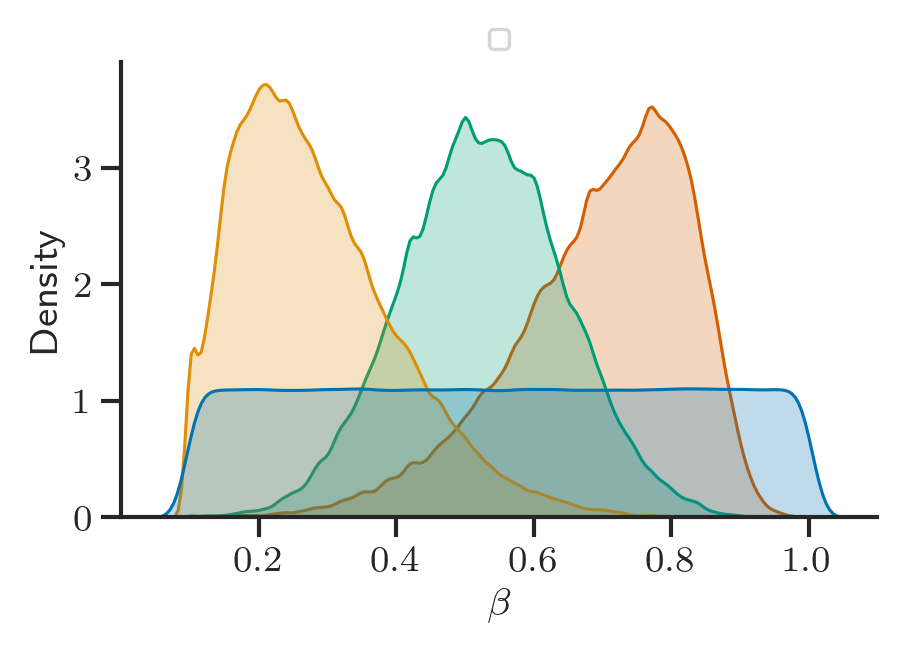

In [54]:
metrics = ['$\\beta$']
for metric in metrics:
    kdeplot(df=df, metric=metric)

# Hist

In [55]:
# %autoreload

# # get rand var vals and probs from dist
# rand_var_name = '$\\beta$'
# df_dict = defaultdict(list)

# for context, dist in context_to_dist.items():
#     df_dict[rand_var_name].extend(dist.random_var_vals)
#     df_dict[rand_var_name+'_prob'].extend(dist.random_var_probs)
#     df_dict['Context'].extend([context for _ in range(len(dist.random_var_vals))])

# # convert to dataframe
# df = pd.DataFrame(df_dict)
# display(df)

In [56]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

estimator = np.mean # np.mean np.median

scaling_factor = 0.5
width_scaling_factor = 1
height_scaling_factor = 1

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 0.5

# xaxis = episode_stats_df['run_time']
xaxis = df['$\\beta$']
xaxis_label = '$\\beta$'

# stat = 'count'
# stat = 'percent'
stat = 'probability'

yaxis_label = 'Probability'

hue = 'Context'

legend = 'auto'
# legend = None

xlim = None
xlim = [0.1, 1]

ylim = None
# ylim = [20, 100]

alpha = 0.25

common_norm = False

# linewidth = aesthetics.linewidth
linewidth = 0.1

fill = True
# fill = False

xaxis_label_style = 'plain' # sci plain
yaxis_label_style = 'plain' # sci plain

bins = 'auto'

binwidth = 0.01
# binwidth = 0.05

kde = True
# kde = False
line_kws = {'linewidth': 0.75}

cumulative = False

element = 'bars'

# ylog = True
ylog = False
# xlog = True
xlog = False


def histplot(df, metric):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    
    g = sns.histplot(data=df, 
                     x=xaxis, 
                     # y=metric, 
                     hue=hue, 
                     legend=legend,
                     # legend=None,
                     alpha=alpha,
                     linewidth=linewidth,
                     fill=fill,
                     common_norm=common_norm,
                     bins=bins,
                     binwidth=binwidth,
                     kde=kde,
                     line_kws=line_kws,
                     stat=stat,
                     element=element,
                     cumulative=cumulative,
                    )
    
    if legend is not None:
        # ax.legend(labels=context_to_dist.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, labelspacing=0.1, columnspacing=3, prop={'size': 4})
        # sns.move_legend(ax, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, labelspacing=0.1, columnspacing=1, prop={'size': 5.5}, title=None, frameon=False)
        sns.move_legend(ax, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, labelspacing=0.1, columnspacing=1, prop={'size': 5.75}, title=None, frameon=False)
    
    # if use_manual_error_bars:
    #     ax.fill_between(xaxis, df[metric+'_min'], df[metric+'_max'], alpha=0.2)
    if xlim is not None:
        plt.xlim(left=xlim[0], right=xlim[1])
    if ylim is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])
    g.set_xlabel(xaxis_label)
    g.set_ylabel(yaxis_label)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    g.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
    g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    if xlog:
        g.set(xscale='log')
    if ylog:
        g.set(yscale='log')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

Plotting metric $\beta$ -> min=0.1 | max=1.0 | mean=0.5141393225000003


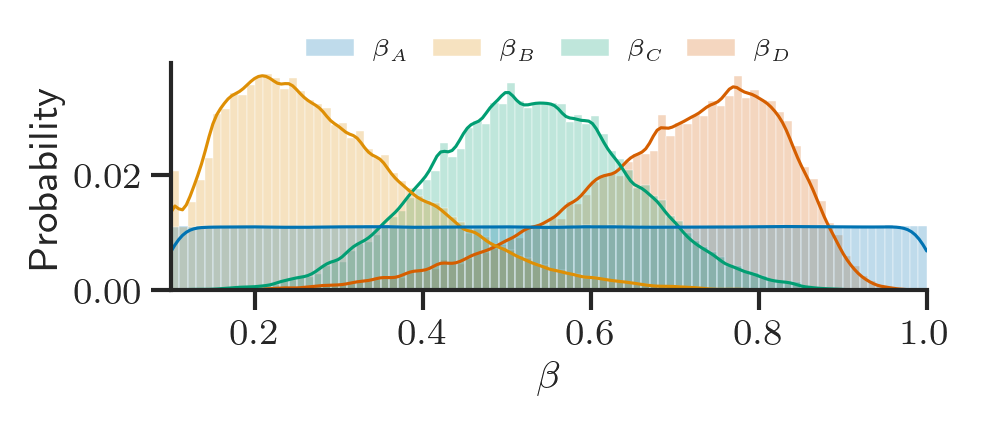

Plotting metric $\beta$ -> min=0.1 | max=1.0 | mean=0.5141393225000003


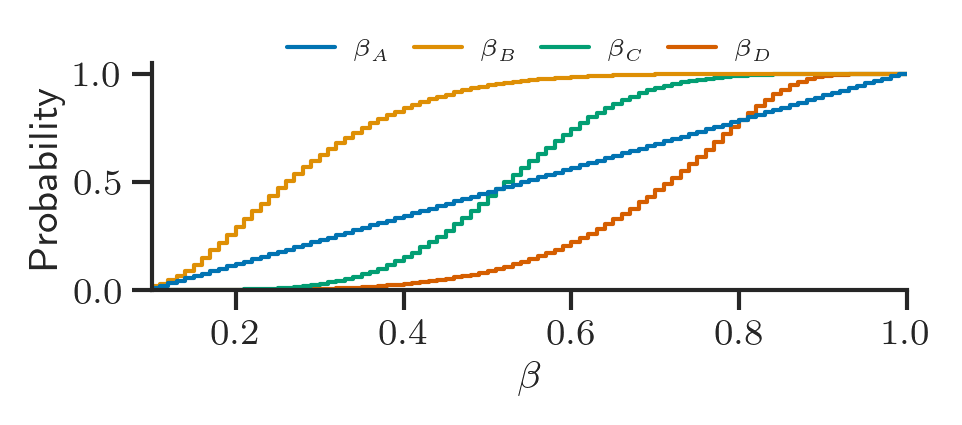

In [57]:
metrics = ['$\\beta$']
for metric in metrics:
    # hist
    histplot(df=df, metric=metric)
    
    # cdf
    orig_element = copy.copy(element)
    element = 'step'
    orig_fill = copy.copy(fill)
    fill = False
    orig_cumulative = copy.copy(cumulative)
    cumulative = True
    orig_kde = copy.copy(kde)
    kde = False
    orig_alpha = copy.copy(alpha)
    alpha = 1
    orig_linewidth = copy.copy(linewidth)
    linewidth = 1
    
    histplot(df=df, metric=metric)
    
    element = orig_element
    fill = orig_fill
    cumulative = orig_cumulative
    kde = orig_kde
    alpha = orig_alpha
    linewidth = orig_linewidth